In [1]:
import numpy as np

In [2]:
class GridWorld:
    """
    A class to represent the Grid World environment for a Markov Decision Process.
    """

    def __init__(self, width, height, start, goal, obstacles, slip_prob=0.2):
        """
        Initializes the Grid World environment.

        Args:
            width (int): The width of the grid.
            height (int): The height of the grid.
            start (tuple): The starting position of the agent (row, col).
            goal (tuple): The goal position (row, col).
            obstacles (list of tuples): A list of obstacle positions.
            slip_prob (float): The probability of the agent slipping and moving in an unintended direction.
        """
        self.width = width
        self.height = height
        self.start = start
        self.goal = goal
        self.obstacles = obstacles
        self.slip_prob = slip_prob

        # States (S)
        self.states = [(r, c) for r in range(height) for c in range(width)]

        # Actions (A)
        self.actions = ['up', 'down', 'left', 'right']

        # Transition Probabilities (P) and Reward Function (R)
        self.P = self._create_transition_probabilities()
        self.R = self._create_reward_function()

    def _create_transition_probabilities(self):
        """
        Creates the transition probability dictionary P(s, a, s').
        """
        P = {}
        for s in self.states:
            if s in self.obstacles or s == self.goal:
                continue
            P[s] = {}
            for a in self.actions:
                P[s][a] = []
                # Intended move
                next_s_intended = self._get_next_state(s, a)
                P[s][a].append((1 - self.slip_prob, next_s_intended))

                # Slips
                slip_actions = [act for act in self.actions if act != a]
                for slip_a in slip_actions:
                    next_s_slip = self._get_next_state(s, slip_a)
                    P[s][a].append((self.slip_prob / len(slip_actions), next_s_slip))
        return P

    def _get_next_state(self, s, a):
        """
        Calculates the next state given a current state and action.
        """
        r, c = s
        if a == 'up':
            r = max(0, r - 1)
        elif a == 'down':
            r = min(self.height - 1, r + 1)
        elif a == 'left':
            c = max(0, c - 1)
        elif a == 'right':
            c = min(self.width - 1, c + 1)
        
        # Check for obstacles
        if (r, c) in self.obstacles:
            return s # Stay in the same state if moving into an obstacle

        return (r, c)

    def _create_reward_function(self):
        """
        Creates the reward dictionary R(s, a, s').
        """
        R = {}
        for s in self.states:
            R[s] = {}
            for a in self.actions:
                R[s][a] = {}
                # Check all possible next states from the transition probabilities
                if s in self.P:
                    for prob, next_s in self.P[s][a]:
                        if next_s == self.goal:
                            R[s][a][next_s] = 10
                        elif next_s in self.obstacles:
                            R[s][a][next_s] = -10
                        else:
                            R[s][a][next_s] = -1 # Reward for each step
        return R

    def print_grid(self, agent_pos=None):
        """
        Prints a simple visualization of the grid.
        """
        for r in range(self.height):
            row_str = ""
            for c in range(self.width):
                if agent_pos and (r, c) == agent_pos:
                    row_str += " A "
                elif (r, c) == self.goal:
                    row_str += " G "
                elif (r, c) in self.obstacles:
                    row_str += " X "
                else:
                    row_str += " . "
            print(row_str)

In [3]:
if __name__ == '__main__':
    # Define the grid world parameters
    grid_width = 5
    grid_height = 5
    start_state = (0, 0)
    goal_state = (4, 4)
    obstacle_states = [(1, 1), (2, 3), (3, 1)]

    # Create the GridWorld environment
    grid_world = GridWorld(
        width=grid_width,
        height=grid_height,
        start=start_state,
        goal=goal_state,
        obstacles=obstacle_states
    )

    # --- Demonstrating the MDP Components ---
    print("--- Markov Decision Process Components ---")

    # States (S)
    print("\nNumber of States:", len(grid_world.states))
    print("Sample States:", grid_world.states[:5])

    # Actions (A)
    print("\nActions:", grid_world.actions)

    # Reward Function (R) - Example for start state and 'right' action
    sample_state = start_state
    sample_action = 'right'
    print(f"\nReward function for state {sample_state} and action '{sample_action}':")
    if sample_state in grid_world.R and sample_action in grid_world.R[sample_state]:
        for next_s, reward in grid_world.R[sample_state][sample_action].items():
            print(f"  - Transition to {next_s} has a reward of {reward}")

    # Transition Probabilities (P) - Example for start state and 'right' action
    print(f"\nTransition probabilities for state {sample_state} and action '{sample_action}':")
    if sample_state in grid_world.P and sample_action in grid_world.P[sample_state]:
        for prob, next_s in grid_world.P[sample_state][sample_action]:
            print(f"  - Probability of moving to {next_s}: {prob:.2f}")

    # --- Grid Visualization ---
    print("\n--- Grid World Visualization ---")
    grid_world.print_grid(agent_pos=start_state)

--- Markov Decision Process Components ---

Number of States: 25
Sample States: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]

Actions: ['up', 'down', 'left', 'right']

Reward function for state (0, 0) and action 'right':
  - Transition to (0, 1) has a reward of -1
  - Transition to (0, 0) has a reward of -1
  - Transition to (1, 0) has a reward of -1

Transition probabilities for state (0, 0) and action 'right':
  - Probability of moving to (0, 1): 0.80
  - Probability of moving to (0, 0): 0.07
  - Probability of moving to (1, 0): 0.07
  - Probability of moving to (0, 0): 0.07

--- Grid World Visualization ---
 A  .  .  .  . 
 .  X  .  .  . 
 .  .  .  X  . 
 .  X  .  .  . 
 .  .  .  .  G 


In [4]:
import random
import networkx as nx
import matplotlib.pyplot as plt

# Simple Markov Chain Example
states = ["Sunny", "Cloudy", "Rainy"] # States of the weather

transition_matrix = [
    [0.7, 0.2, 0.1], # Sunny -> Sunny, Cloudy, Rainy
    [0.3, 0.4, 0.3], # Cloudy -> Sunny, Cloudy, Rainy
    [0.2, 0.5, 0.3]  # Rainy -> Sunny, Cloudy, Rainy
]

In [5]:
def markov_chain(start_state, days):
    """This function simulates a Markov chain for weather states over a number of days."""
    current_state = start_state
    weather_sequence = [current_state]
    
    for _ in range(days):
        next_state_probs = transition_matrix[states.index(current_state)]
        current_state = random.choices(states, weights=next_state_probs)[0]
        weather_sequence.append(current_state)
    
    return weather_sequence
    

In [9]:
def plot_markov_chain(states, transition_matrix):
    G = nx.DiGraph()

    # Add nodes
    for state in states:
        G.add_node(state)

    # Add edges with weights
    for i, from_state in enumerate(states):
        for j, to_state in enumerate(states):
            prob = transition_matrix[i][j]
            if prob > 0:
                G.add_edge(from_state, to_state, weight=prob, label=f"{prob:.2f}")

    pos = nx.spring_layout(G, seed=42)  # Layout for consistent positions
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=12, arrowsize=20)

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title("Markov Chain State Diagram")
    plt.show()

In [7]:
sequence = markov_chain("Cloudy", 10)
print(sequence)

['Cloudy', 'Rainy', 'Cloudy', 'Rainy', 'Cloudy', 'Cloudy', 'Sunny', 'Sunny', 'Cloudy', 'Cloudy', 'Cloudy']


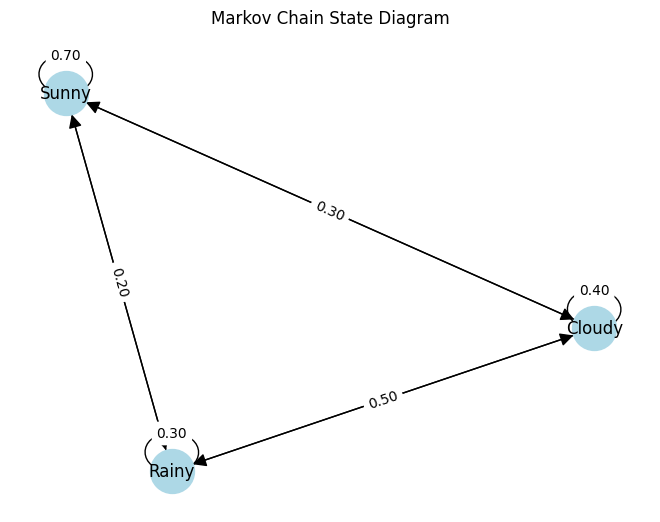

In [ ]:
# Visualize the markov chain
plot_markov_chain(states, transition_matrix)

In [1]:
# An instance of a Markov Reward Process (MRP)
import numpy as np

states = {0: "Facebook", 1: "Class", 2: "Sleep"} # States -> Browsing Facebook, Attending a class, Sleeping

# Transition probability matrix
P = np.array([
    [0.9, 0.1, 0.0],  # Facebook -> Facebook, Class, Sleep.
    [0.5, 0.0, 0.5],  # Class -> Facebook, Class, Sleep.
    [0.0, 0.0, 1.0]   # Sleep -> Facebook, Class, Sleep. Sleep is a terminal state.
    ])

# Reward Function
R = np.array([-1, -2, 0])  # Rewards for being in each state: Facebook (-1), Class (-2), Sleep (0)

# Discount Factor
gamma = 0.9

In [17]:
def simulate_episode(start_state, max_steps=10):
    """Simulates an episode of the MRP starting from a given state."""
    episode = []
    current_state = start_state
    
    for _ in range(max_steps):
        episode.append(current_state)
        if current_state == 2:  # If we reach the terminal state (Sleep)
            break
        next_state = np.random.choice(len(states), p=P[current_state])
        current_state = next_state
    return episode

episode_simulation = simulate_episode(1)  # Start from Class
print(f"Simulated Episode(by state index): {episode_simulation}")
print(f"Simulated Episode(by state name): {[states[s] for s in episode_simulation]}")

Simulated Episode(by state index): [1, 0, 0, 0, 1, 2]
Simulated Episode(by state name): ['Class', 'Facebook', 'Facebook', 'Facebook', 'Class', 'Sleep']


In [ ]:
# Computing the returns for an episode
def compute_return(episode, rewards, discount_factor):
    """Calculates the returns for a given episode."""
    G = 0
    for i, state in enumerate(episode):
        G += (discount_factor ** i) * rewards[state]
    return G

# Example usage of compute_returns
episode_rewards = [R[s] for s in episode_simulation]
total_return = compute_return(episode_simulation, R, gamma)
print(f"\nRewards for the episode: {episode_rewards}")
print(f"Total Return for the episode: {total_return}")


Rewards for the episode: [np.int64(-2), np.int64(-1), np.int64(-1), np.int64(-1), np.int64(-2), np.int64(0)]
Total Return for the episode: -5.7512
